In [2]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
from scipy.fft import rfft, rfftfreq

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Initial clean up and graphing of magnitude data
## Data smoothed using rolling average

Max magnitude: 19.09
Mean magnitude (absolute difference from stationary): 7.98
Mean magnitude: 17.79


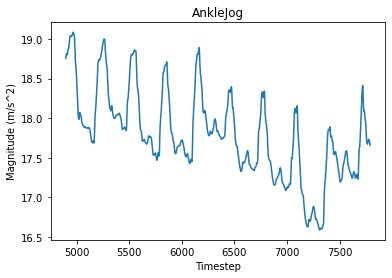

Max magnitude: 13.54
Mean magnitude (absolute difference from stationary): 3.25
Mean magnitude: 13.06


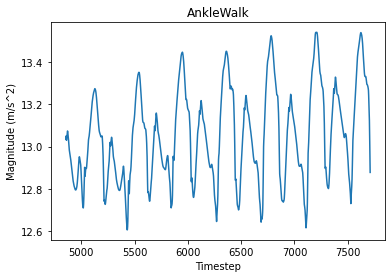

Max magnitude: 25.5
Mean magnitude (absolute difference from stationary): 14.34
Mean magnitude: 24.15


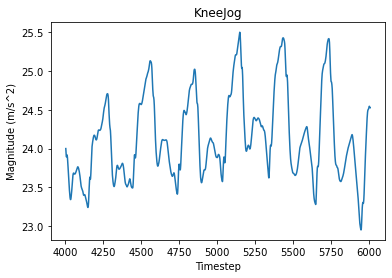

Max magnitude: 13.55
Mean magnitude (absolute difference from stationary): 3.3
Mean magnitude: 13.11


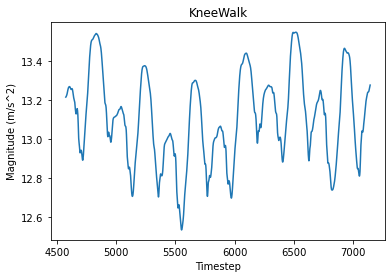

Max magnitude: 14.26
Mean magnitude (absolute difference from stationary): 3.81
Mean magnitude: 13.62


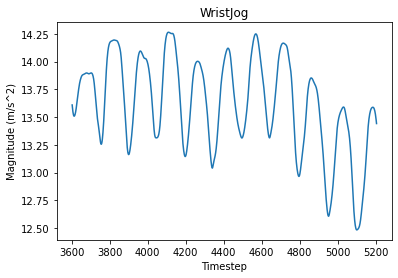

Max magnitude: 10.27
Mean magnitude (absolute difference from stationary): 0.2
Mean magnitude: 10.0


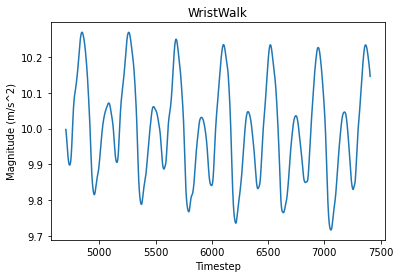

In [13]:
for f in glob('data\*.csv'):
        df = pd.read_csv(f)
        cols = ['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)',
                'Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)']
        df['magnitude'] = np.sqrt(np.square(df['Acceleration x (m/s^2)']) + np.square(df['Acceleration y (m/s^2)']) + np.square(df['Acceleration z (m/s^2)']))
        q1, q2 = df['Time (s)'].quantile([.3, .6])
        df_trimmed = df[(df['Time (s)']>= q1) & (df['Time (s)'] <= q2)]
        #df_trimmed['magnitude'] = np.sqrt(np.square(df_trimmed['Acceleration x (m/s^2)']) + np.square(df_trimmed['Acceleration y (m/s^2)']) + np.square(df_trimmed['Acceleration z (m/s^2)']))
        rolling = df_trimmed['magnitude'].rolling(1000).mean()
        df_trimmed['magnitude'] = rolling

        left = 'data\\'
        right = '_'
        print('Max magnitude:', np.round(df_trimmed['magnitude'].max(), 2))
        print('Mean magnitude (absolute difference from stationary):', np.round(np.mean(np.abs(df_trimmed['magnitude']-9.81)), 2))
        print('Mean magnitude:', np.round(df_trimmed['magnitude'].mean(), 2))
        df_trimmed['magnitude'].plot()
        plt.title(f[f.index(left)+len(left):f.index(right)])
        #df_trimmed.to_csv('cleaned_data\\' + f[f.index(left)+len(left):f.index(right)]+'.csv', index=False)
        plt.xlabel('Timestep')
        plt.ylabel('Magnitude (m/s^2)')
        plt.savefig('figures\\' + f[f.index(left)+len(left):f.index(right)]+'.png')
        plt.show()

# Frequency data
## Data run through a low-pass Butterworth filter

In [14]:
from scipy.signal import butter, lfilter, freqz


def butter_lowpass(cutoff, fs, order=5):
        return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

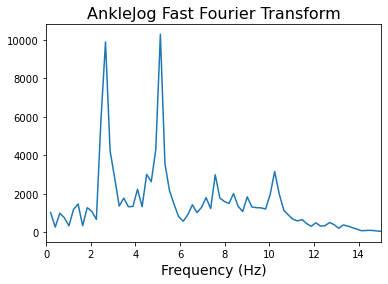

AnkleJog
Highest Magnitude Hz 4.9162405644764435


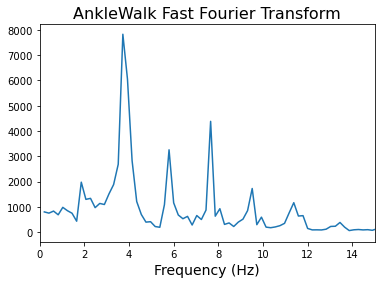

AnkleWalk
Highest Magnitude Hz 3.5185252786787182


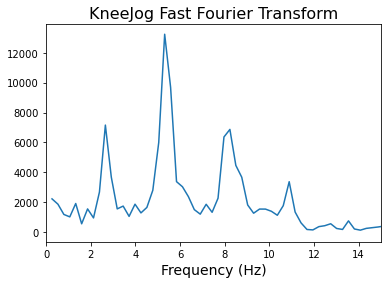

KneeJog
Highest Magnitude Hz 5.047660680964709


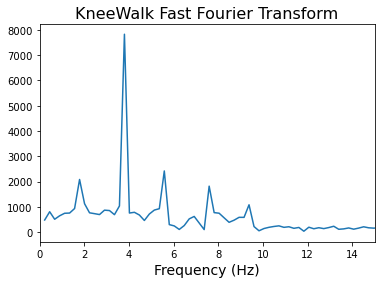

KneeWalk
Highest Magnitude Hz 3.5727781094067135


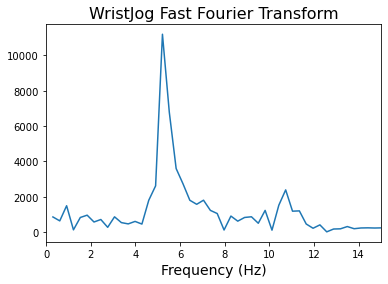

WristJog
Highest Magnitude Hz 4.907297157891162


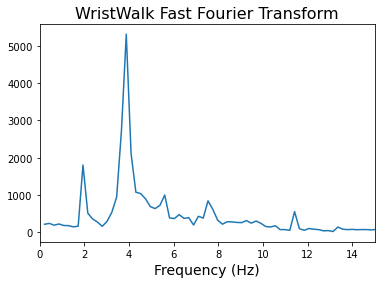

WristWalk
Highest Magnitude Hz 3.6628054602711244


In [15]:
for f in glob('data\*.csv'):
        df = pd.read_csv(f)
        cols = ['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)',
                'Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)']
        df['magnitude'] = np.sqrt(np.square(df['Acceleration x (m/s^2)']) + np.square(df['Acceleration y (m/s^2)']) + np.square(df['Acceleration z (m/s^2)']))
        q1, q2 = df['Time (s)'].quantile([.3, .6])
        df_trimmed = df[(df['Time (s)']>= q1) & (df['Time (s)'] <= q2)]
        df_trimmed = df_trimmed.dropna()

        left = 'data\\'
        right = '_'
        N = len(df_trimmed)
        SAMPLE_RATE = 1/df_trimmed['Time (s)'].diff().mean()

        # Filter requirements.
        order = 6
        fs = SAMPLE_RATE       # sample rate, Hz
        cutoff = 5  # desired cutoff frequency of the filter, Hz

        y = butter_lowpass_filter(df_trimmed['magnitude'].values, cutoff, fs, order)

        yf = rfft(y, n=N)
        freq_magnitude = np.abs(yf)
        freq_axis = np.linspace(0, SAMPLE_RATE, len(freq_magnitude))
        #freq_axis = rfftfreq(len(y))
        plt.plot(freq_axis[1:], freq_magnitude[1:])
        plt.title(f[f.index(left)+len(left):f.index(right)] + ' Fast Fourier Transform', fontsize=16)
        plt.xlabel('Frequency (Hz)', fontsize=14)
        plt.xlim(0,15)
        plt.savefig('figures\\' + f[f.index(left)+len(left):f.index(right)]+'_fft.png')
        plt.show()
        print(f[f.index(left)+len(left):f.index(right)] + '\nHighest Magnitude Hz ' + str(freq_axis[freq_magnitude[1:].argmax()]))

# Low Pass Filter Response
## Used to determine parameters for Buttersworth filter

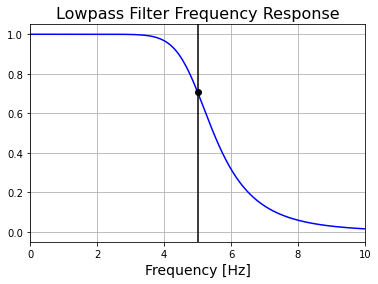

In [16]:
df = pd.read_csv('data/AnkleJog_RawData.csv')
cols = ['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)',
        'Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)']
df['magnitude'] = np.sqrt(np.square(df['Acceleration x (m/s^2)']) + np.square(df['Acceleration y (m/s^2)']) + np.square(df['Acceleration z (m/s^2)']))
q1, q2 = df['Time (s)'].quantile([.3, .6])
df_trimmed = df[(df['Time (s)']>= q1) & (df['Time (s)'] <= q2)]
df_trimmed = df_trimmed.dropna()

left = 'data\\'
right = '_'
N = len(df_trimmed)

order = 6
fs = SAMPLE_RATE      # sample rate, Hz
cutoff = 5  # desired cutoff frequency of the filter, Hz

b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=len(df_trimmed))
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.title("Lowpass Filter Frequency Response", fontsize=16)
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.xlim(0,10)
plt.grid()
plt.savefig('figures\low_pass_filter_response.png')